<a href="https://colab.research.google.com/github/chelsea591/Machine_Learning_Qlab_PC/blob/main/PC3/PC_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Práctica Calificada 3: Aplicaciones de Redes Neuronales**

**Integrantes:**
* Lesly Guzmán (20212335)
* Angie Quispe (20231371)
* Chelsea Torres (20200891)

##**Parte 1: Clasificación con Random Forest en Datos Desbalanceados**
En esta sección, trabajarán con el dataset `prediccion_pobreza_peru2.csv`. El objetivo es
construir un modelo de Machine Learning capaz de identificar hogares en situación de pobreza
monetaria.

**1.1. Preparación y Preprocesamiento**

**a) Carga e Inspección:** Cargue el dataset y separe las variables predictoras (X) de la
variable objetivo (`Y: PobrezaMonetaria`). Identifique y separe las columnas numéricas de
las categóricas.

In [ ]:
# Importamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Cargamos e inspeccionamos la data
df = pd.read_csv('prediccion_pobreza_peru2.csv')
df.head()

,EdadJefeHogar,SexoJefeHogar,MiembrosHogar,RatioDependencia,LenguaMaterna,NivelEducativoJefeHogar,AniosEstudioJefeHogar,TipoEmpleo,IngresoMensualHogar,GastoMensualHogar,AreaResidencia,TenenciaVivienda,MaterialParedes,AccesoAguaPotable,AccesoSaneamiento,AccesoElectricidad,Hacinamiento,PoseeActivos,Region,PobrezaMonetaria
0,18,Hombre,4,2.05,Español,Secundaria,12,Informal,1832.11,1409.30,Urbana,Propia,Adobe,0,0,1,0,0,Costa,0
1,83,Mujer,1,0.83,Quechua,Primaria,8,Informal,150.00,138.47,Rural,Alquilada,Madera/Esteras,1,1,1,0,1,Sierra,0
2,52,Hombre,8,2.48,Español,Primaria,8,Informal,150.00,154.19,Rural,Alquilada,Adobe,0,0,1,1,0,Selva,1
3,27,Hombre,4,1.08,Español,Secundaria,12,Formal,1778.65,1630.14,Urbana,Propia,Adobe,0,0,0,0,0,Costa,0
4,84,Mujer,5,3.13,Español,Secundaria,12,Informal,1277.27,1074.96,Urbana,Propia,Adobe,0,0,1,0,0,Sierra,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EdadJefeHogar            5000 non-null   int64  
 1   SexoJefeHogar            5000 non-null   object 
 2   MiembrosHogar            5000 non-null   int64  
 3   RatioDependencia         5000 non-null   float64
 4   LenguaMaterna            5000 non-null   object 
 5   NivelEducativoJefeHogar  5000 non-null   object 
 6   AniosEstudioJefeHogar    5000 non-null   int64  
 7   TipoEmpleo               5000 non-null   object 
 8   IngresoMensualHogar      5000 non-null   float64
 9   GastoMensualHogar        5000 non-null   float64
 10  AreaResidencia           5000 non-null   object 
 11  TenenciaVivienda         5000 non-null   object 
 12  MaterialParedes          5000 non-null   object 
 13  AccesoAguaPotable        5000 non-null   int64  
 14  AccesoSaneamiento       

In [ ]:
df.isnull().sum()

,0
EdadJefeHogar,0
SexoJefeHogar,0
MiembrosHogar,0
RatioDependencia,0
LenguaMaterna,0
NivelEducativoJefeHogar,0
AniosEstudioJefeHogar,0
TipoEmpleo,0
IngresoMensualHogar,0
GastoMensualHogar,0


In [ ]:
print(f"\nEl dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")


El dataset tiene 5000 filas y 20 columnas.


In [ ]:
# Separamos las variables predictoras de la variable objetivo (PobrezaMonetaria)
X = df.drop(['PobrezaMonetaria','GastoMensualHogar', 'IngresoMensualHogar'], axis=1)
Y = df['PobrezaMonetaria']

In [ ]:
# Identificamos las columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"\nColumnas Numéricas ({len(numerical_cols)}): {list(numerical_cols)}")
print(f"\nColumnas Categóricas ({len(categorical_cols)}): {list(categorical_cols)}")


Columnas Numéricas (9): ['EdadJefeHogar', 'MiembrosHogar', 'RatioDependencia', 'AniosEstudioJefeHogar', 'AccesoAguaPotable', 'AccesoSaneamiento', 'AccesoElectricidad', 'Hacinamiento', 'PoseeActivos']

Columnas Categóricas (8): ['SexoJefeHogar', 'LenguaMaterna', 'NivelEducativoJefeHogar', 'TipoEmpleo', 'AreaResidencia', 'TenenciaVivienda', 'MaterialParedes', 'Region']


**b) División Estratificada:** Divida los datos en entrenamiento (70 %) y prueba (30 %) utilizando `train_test_split`. Es fundamental usar el parámetro `stratify=y` ¿Para qué se
usa este parámetro? Explique.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

**Explicación:** El parámetro `stratify=Y` es importante porque nos permite mantener la proporción de hogares pobres y no pobres tanto en el conjunto de prueba como entrenamiento. De esta manera, se evita que el algoritmo caiga en un sesgo.

**c) Análisis de Desbalance:** Calcule y reporte la proporción de clases (0: No Pobre, 1:
Pobre) en el conjunto de entrenamiento. ¿Ante que tipo de data nos encontramos?

In [ ]:
print("Distribución de la variable objetivo en el conjunto original:")
print(Y.value_counts(normalize=True))

print("\nDistribución en el conjunto de entrenamiento:")
print(Y_train.value_counts(normalize=True))

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]} hogares")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} hogares")

Distribución de la variable objetivo en el conjunto original:
PobrezaMonetaria
0    0.7
1    0.3
Name: proportion, dtype: float64

Distribución en el conjunto de entrenamiento:
PobrezaMonetaria
0    0.7
1    0.3
Name: proportion, dtype: float64

Tamaño del conjunto de entrenamiento: 3500 hogares
Tamaño del conjunto de prueba: 1500 hogares


**Respuesta:** Nos encontramos ante un data set balanceado, ya que la proporción en el conjunto de prueba y de entrenamiento, luego de la división de datos, es la misma.

**1.2. Construcción del Pipeline Estándar**

**a) Preprocesador:** Construya un ColumnTransformer que aplique:
* `StandardScaler` a las variables numéricas.
* `OneHotEncoder` a las variables categóricas (use `handle_unknown=’ignore’`).

In [ ]:
# Creamos el pipeline para las variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

**b) Pipeline:** Implemente un Pipeline estándar de Scikit-Learn que contenga dos pasos:
1. El preprocesador definido anteriormente.
2. Un clasificador `RandomForestClassifier` (con `random_state=42`).

In [ ]:
# Creamos el preprocesador usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

In [ ]:
# Creamos el clasificador RandomForestClassifier
rfc_model = RandomForestClassifier(random_state=42)

In [ ]:
# Creamos el pipeline completo
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rfc_model)
])

full_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['EdadJefeHogar', 'MiembrosHogar', 'RatioDependencia',
       'AniosEstudioJefeHogar', 'AccesoAguaPotable', 'AccesoSaneamiento',
       'AccesoElectricidad', 'Hacinamiento', 'PoseeActivos'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['SexoJefeHogar', 'LenguaMaterna', 'NivelEducativoJefeHogar',
       'TipoEmpleo', 'AreaResidencia', 'TenenciaVivienda', 'MaterialParedes',
       'Region'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

**c) Entrenamiento Base:** Entrene este pipeline con los hiperparámetros por defecto. Muestre el Classification Report, matriz de confusion y Curva ROC del conjunto de prueba.
Note el valor de Recall para la clase 1 (Pobre). ¿El modelo base es bueno detectando a
los pobres?

In [ ]:
# Entrenamos el pipeline
Y_pred = full_pipeline.predict(X_test)
Y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1] #La segunda columna (índice 1) contiene la probabilidad de que la instancia pertenezca a la clase 1 ('Pobre' en este caso)

# Mostramos el Classification Report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=['No Pobre (0)', 'Pobre (1)']))

# Calculamos y mostramos Accuracy y ROC-AUC Score
accuracy = accuracy_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred_proba)
print(f"\nAccuracy (Exactitud): {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

No Pobre (0)       0.84      0.87      0.85      1050
   Pobre (1)       0.66      0.61      0.64       450

    accuracy                           0.79      1500
   macro avg       0.75      0.74      0.74      1500
weighted avg       0.79      0.79      0.79      1500


Accuracy (Exactitud): 0.7893
ROC-AUC Score: 0.8568



Confusion Matrix:


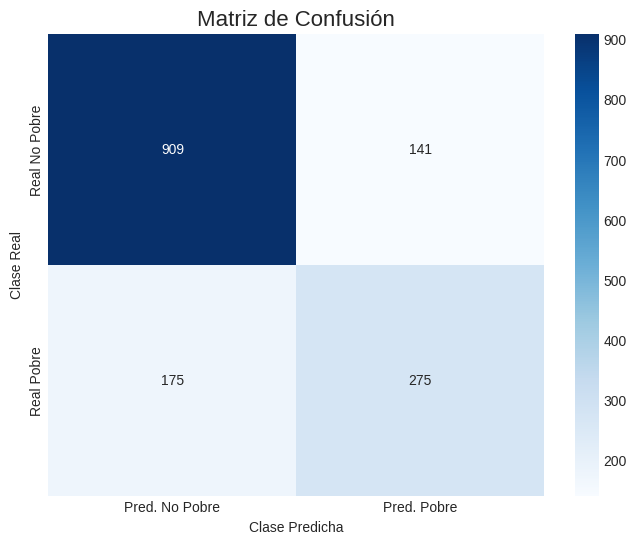

In [ ]:
# Mostramos la Matriz de Confusión
print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Pred. No Pobre', 'Pred. Pobre'], yticklabels=['Real No Pobre', 'Real Pobre'])
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


Curva ROC:


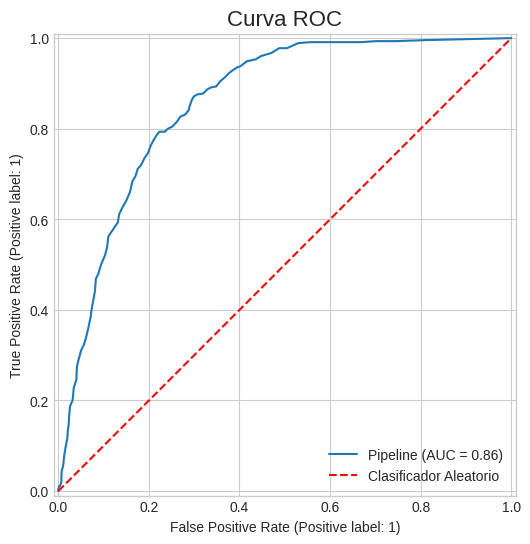

In [ ]:
# Mostramos la Curva ROC
print("\nCurva ROC:")
fig, ax = plt.subplots(figsize=(8, 6))
roc_display = RocCurveDisplay.from_estimator(full_pipeline, X_test, Y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Clasificador Aleatorio')
ax.set_title('Curva ROC', fontsize=16)
plt.legend()
plt.show()

In [ ]:
# Calculamos el Recall para la clase 1 (Pobre)
report = classification_report(Y_test, Y_pred, output_dict=True)
recall_class_1 = report['1']['recall']
print(f"\nRecall para la clase 1 (Pobre): {recall_class_1:.2f}")


Recall para la clase 1 (Pobre): 0.61


**Respuesta:** En base a un Recall de 0.61 para la clase 1 (Pobre), se puede concluir que el modelo base no es bueno detectando a los hogares pobres, ya que el modelo solo identifica correctamente al 61% de los hogares que son realmente pobres.

## **Parte 2: Red Neuronal para Predicción de Precios de Viviendas en California**


**2.1. Preparación de Datos**

a) Carga: Importe la función necesaria y cargue los datos:

In [17]:
# Importamos las librerias y funciones necesarias
import numpy as np
import pandas as pd
import sklearn.model_selection as skm
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
# Cargamos los datos
housing = fetch_california_housing()
X, y = housing.data, housing.target

In [19]:
# Mostramos dimensiones iniciales
print(f"Dataset original X: {X.shape}")
print(f"Dataset original y: {y.shape}")

Dataset original X: (20640, 8)
Dataset original y: (20640,)


b) División: Divida los datos en conjuntos de entrenamiento (75 %) y prueba (25 %) utilizando train test split y un random state para reproducibilidad.

In [20]:
# Usamos random_state=42 para reproducibilidad.
X_train, X_test, y_train, y_test = skm.train_test_split(
    X, y,
    test_size=0.25,  # 25% para prueba
    random_state=42
)

In [21]:
print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (15480, 8)
Test shape:  (5160, 8)


c) Escalamiento: Las redes neuronales son sensibles a la escala de los datos.

In [22]:
# Las redes neuronales requieren que los datos tengan una escala similar (media 0, var 1) para converger más rápido.

scaler = StandardScaler()

In [23]:
# Ajustamos (fit) SOLO con el conjunto de entrenamiento para evitar la filtración de información del test al train.
scaler.fit(X_train)

StandardScaler()

In [24]:
# Transformamos ambos conjuntos con los parámetros aprendidos del train
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
print("Verificación del Escalamiento:")
print(f"Media de X_train_scaled (debería ser cercano a 0): {np.mean(X_train_scaled):.2f}")
print(f"Desviación Estándar de X_train_scaled (debería ser cercano a 1): {np.std(X_train_scaled):.2f}")


Verificación del Escalamiento:
Media de X_train_scaled (debería ser cercano a 0): -0.00
Desviación Estándar de X_train_scaled (debería ser cercano a 1): 1.00


**2.2. Implementación y Comparación de Modelos**

In [26]:
# Importamos lo necesario:
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

a) Modelo Base (Regresión Lineal): Entrene una Regresión Lineal con los datos de entrenamiento escalados. Evalúela en el conjunto de prueba calculando el MSE.

In [27]:
# 1. Entrenamos la regresion lineal (usando datos escalados)
lr_model = skl.LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 2. Predecir y evaluar
y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

print(f"MSE Regresión Lineal: {mse_lr:.4f}")

MSE Regresión Lineal: 0.5411


b) Red Neuronal (MLP): Diseñe una arquitectura capaz de capturar no-linealidades. Se sugiere:
- Capa de entrada adecuada a la dimensión de los datos.
- **Dos capas ocultas** con función de activación `relu`.

In [28]:
# Diseño de la Arquitectura
model = Sequential()

# Primera capa oculta (y entrada explícita)
# Usamos 64 neuronas como punto de partida
model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))

# Segunda capa oculta
model.add(Dense(32, activation='relu'))

# Capa de salida (sin activación para regresión pura)
# La capa de salida tiene 1 sola neurona (porque predecimos un valor continuo: el precio) y no tiene función de activación (es lineal), lo cual es estándar para una regresión.
model.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c) Entrenamiento: Compile el modelo usando `los=’mse’` y un optimizador como `Adam`. Entrene por al menos 20-30 épocas. Use un `validation_split` del 20% para monitorear que no haya sobreajuste.

In [29]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Entrenamiento
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2, # 20% del train para validar en cada época
    verbose=1
)

Epoch 1/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9357 - val_loss: 0.4144
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3732 - val_loss: 0.3901
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3403 - val_loss: 0.3608
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3524 - val_loss: 0.3485
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3285 - val_loss: 0.3621
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3181 - val_loss: 0.3777
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3059 - val_loss: 0.3412
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3045 - val_loss: 0.3742
Epoch 9/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3377 - val_loss: 0.3359
Epoch 10/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3027 - val_loss: 0.3656
Epoch 11/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3303 - val_loss: 0.3500
Epoch 12/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

d) Evaluación: Calcule el MSE de la Red Neuronal en el conjunto de prueba y compárelo con el de la Regresión Lineal.

In [30]:
y_pred_nn = model.predict(X_test_scaled)
mse_nn = mean_squared_error(y_test, y_pred_nn)

print(f"MSE Red Neuronal: {mse_nn:.4f}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
MSE Red Neuronal: 0.2805


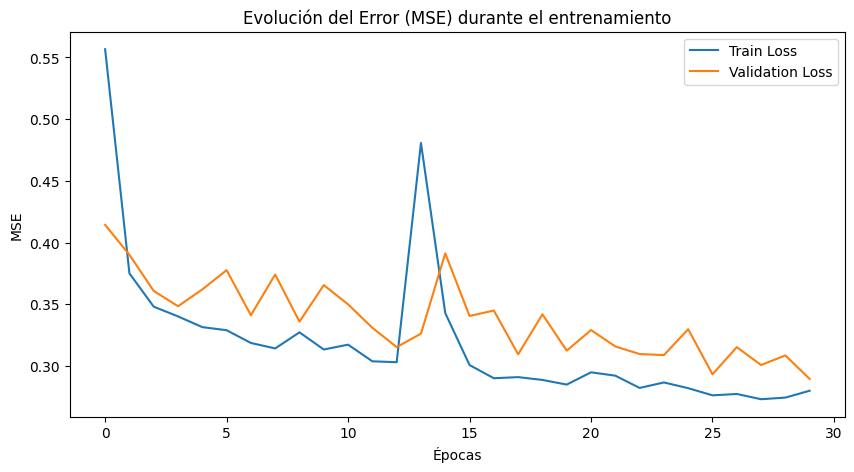

In [31]:
# Grafico de perdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución del Error (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

e) Preguntas de Interpretación: Reporte los MSE de ambos modelos. ¿Hubo una mejora significativa al usar la Red Neuronal? Explique


In [32]:
print(f"1. Regresión Lineal MSE: {mse_lr:.4f}")
print(f"2. Red Neuronal MSE:     {mse_nn:.4f}")

mejora = mse_lr - mse_nn

print(f"Mejora: {mejora:.4f}")

1. Regresión Lineal MSE: 0.5411
2. Red Neuronal MSE:     0.2805
Mejora: 0.2606


- Vemos que la Red Neuronal redujo el error.
- Esto indica que este modelo capturó relaciones no lineales que la regresión simple no pudo ver.
- Este mejor rendimiento se puede deber a que los precios de las casas dependen de interacciones complejas (no lineales) entre las variables, algo que la Regresión Lineal simple no puede capturar bien.

## **Parte 3: Red Neuronal Convolucional para Clasificación de Moda**

### **3.1. Carga y Preparación de Datos**

#### **a) Cargue el dataset ```Fashion-MNIST``` directamente desde Keras.**


In [40]:
# Importar la base
import keras

# TensorFlow
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### **b) Preprocese las imágenes: normalice los valores de los pixeles y asegúrese de que tengan la forma correcta para ser procesadas por una capa convolucional.**


In [34]:
# Load Fashion_mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)
print(x_test.shape)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


#### **c) Convierta las etiquetas de clase a un formato categórico.**

In [35]:
# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

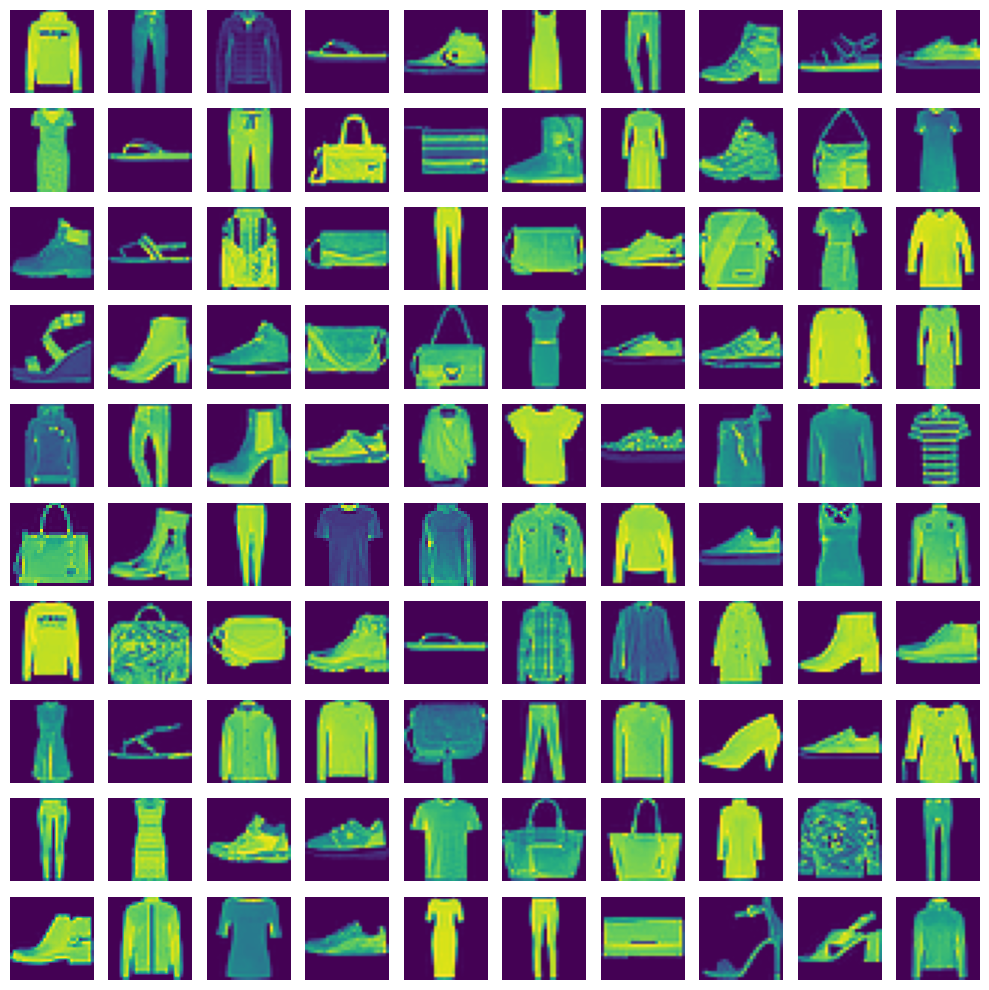

In [36]:
# Veamos las imágenes
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
index = np.random.choice(range(50000), size=100, replace=False)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[index[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

### **3.2. Diseño y Evaluación de la CNN**

#### **a) Diseñe e implemente una Red Neuronal Convolucional (CNN). Su modelo debe incluir al menos dos capas convolucionales y al menos una capa de pooling.**

In [41]:
# Build the model
model = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **b) Compile y entrene su modelo. Monitoree el rendimiento tanto en el conjunto de entrenamiento como en un conjunto de validación durante el entrenamiento.**

In [42]:
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 211ms/step - accuracy: 0.6644 - loss: 0.9010 - val_accuracy: 0.8624 - val_loss: 0.3720
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 225ms/step - accuracy: 0.8554 - loss: 0.3953 - val_accuracy: 0.8836 - val_loss: 0.3202
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 204ms/step - accuracy: 0.8799 - loss: 0.3281 - val_accuracy: 0.8884 - val_loss: 0.2995
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - accuracy: 0.8915 - loss: 0.2914 - val_accuracy: 0.9021 - val_loss: 0.2612
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 205ms/step - accuracy: 0.8994 - loss: 0.2705 - val_accuracy: 0.9101 - val_loss: 0.2424
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 204ms/step - accuracy: 0.9056 - loss: 0.2499 - val_accuracy: 0.9122 - val_loss: 0.2424
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 204ms/step - accuracy: 0.9155 - loss: 0.2300 - val_accuracy: 0.9068 - val_loss: 0.2594
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 205ms/step - accuracy: 0.9178 - loss: 0

#### **d) Explique brevemente el rol de las capas convolucionales y de pooling en su arquitectura.**

- **Rol de las capas:**

  1. **Capas Convolucionales:** Funcionan como extractores de características. Utilizan filtros (kernels) que recorren la imagen para identificar patrones como bordes, texturas y formas específicas (por ejemplo, el cuello de una prenda o la curvatura de un zapato).

  2. **Capas de Pooling (MaxPooling):** Su función es la reducción de dimensionalidad. Al quedarse con el valor máximo de una región, ayudan a que el modelo sea invariante y reducen la carga computacional, evitando el sobreajuste.

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Definir los nombres de las categorías de ropa
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Matriz de Confusión
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_cnn, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Matriz de Confusión: Fashion-MNIST', fontsize=16)
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()


Matriz de Confusión:


NameError: name 'y_pred' is not defined

**¿Hubo alguna categoría de ropa con la que su modelo tuvo más dificultades? ¿A qué cree que se deba? (Puede usar la matriz de confusión para responder).**
- Se observa que la categoría de ropa con la que el modelo tuvo más dificultades fue 'Shirt' (Camisa). Esto se debe a la gran similitud estructural que comparte con prendas como 'T-shirt/top', 'Pullover' y 'Coat'. Debido a que la resolución de las imágenes es de solo 28 x 28 píxeles, detalles cruciales que diferencian a estas prendas (como los botones o el tipo de cuello) se pierden o se vuelven difusos. Especialmente en el caso de las 'T-shirts', el patrón de píxeles termina siendo casi idéntico al de las camisas, lo que induce al error en el modelo. Por el contrario, categorías como 'Trouser' (Pantalones) o 'Bag' (Bolsos) presentan siluetas mucho más sencillas de identificar al ser morfológicamente distintas al resto, permitiendo que la precisión en estas clases sea cercana al 100%.